In [ ]:
%load_ext autoreload
%autoreload 2

Улучшения которые были произведены:


*   Уменьшенный и фиксированный размер входного изображения
*   Добавление датасета и даталоадера, обработка батчами
*   Уменьшение скорости обработки в 4.8 раз

Что еще можно улучшить:
*   Конвертация модели в ONNX/OpenVINO
*   Препроцессинг: нормализация под домен (синтетические картинки)








In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 401 (delta 130), reused 121 (delta 121), pack-reused 235
Receiving objects: 100% (401/401), 12.84 MiB | 31.69 MiB/s, done.
Resolving deltas: 100% (206/206), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


## Download Grounding DINO Weights 🏋️

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


## Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7z x /content/drive/MyDrive/tasks.7z #предварительно загрузить архив на диск


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 936187864 bytes (893 MiB)

Extracting archive: /content/drive/MyDrive/tasks.7z
--
Path = /content/drive/MyDrive/tasks.7z
Type = 7z
Physical Size = 936187864
Headers Size = 536637
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 930 - tasks/squirrels_head/07fd7d3df874a92e.json                                                       0% 1302 - tasks/squirrels_head/12ac895a80c5a1e4.json                                                      

In [ ]:
import json
import os
import numpy as np
import cv2
import math
import datetime
import supervision as sv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from scipy.spatial import distance
import torch
from PIL import Image
import torchvision.transforms as T
from typing import Tuple, List
from groundingdino.util.slconfig import SLConfig
from torch.utils.data import Dataset, DataLoader

import datetime
from tqdm.notebook import tqdm

In [ ]:
TASKS_DIR = '/content/GroundingDINO/tasks'
BOX_TRESHOLD = 0.2
TEXT_TRESHOLD = 0.25
device = 'cuda'

In [ ]:

def detect(images, text_prompts, real_centers,  model, box_threshold = 0.2, text_threshold = 0.25, device='cuda'):
    model = model.to(device)

    captions = [preprocess_caption(caption) for caption in text_prompts]

    images = images.to(device)

    with torch.no_grad():
        outputs = model(images, captions=captions)

    prediction_logits = outputs["pred_logits"].cpu().sigmoid()  # prediction_logits.shape = (bsz，nq, 256)
    prediction_boxes = outputs["pred_boxes"].cpu()  # prediction_boxes.shape = (bsz, nq, 4)

    logits_res = []
    boxs_res = []
    centers_res = []
    dists_res = []
    for ub_logits, ub_boxes, gt_center in zip(prediction_logits, prediction_boxes, real_centers):
        mask = ub_logits.max(dim=1)[0] > box_threshold
        logits = ub_logits[mask]  # logits.shape = (n, 256)
        boxes = ub_boxes[mask]  # boxes.shape = (n, 4)
        logits_res.append(logits.max(dim=1)[0])
        boxes_area = [elem[2]*elem[3] for elem in boxes.tolist()]
        box_idx = np.argmin(boxes_area)
        x_center, y_center = boxes.tolist()[box_idx][:2]
        gt_x, gt_y = gt_center[0], gt_center[1]
        centers_res.append((x_center, y_center))
        dist = distance.euclidean((gt_x,gt_y), (x_center, y_center))
        dists_res.append(dist)
    return centers_res, logits_res, dists_res

In [ ]:
transforms = T.Compose(
          [
          # T.RandomResize([800], max_size=1333),
          T.Resize((320, 320)),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

         ])

In [ ]:

class CustomDataset(Dataset):

    def __init__(self, root_dir, task, transforms=None, device='cpu'):
        self.task = task
        self.root_dir = root_dir
        self.transforms = transforms
        self.device = device
        self.valid_jsons = self.__get_valid_jsons__()

    def __get_valid_jsons__(self):
      json_paths = [elem for elem in glob(f"{os.path.join(self.root_dir, self.task)}/*.json")  if os.stat(elem).st_size > 2]
      return json_paths

    def __len__(self):
        return len(self.valid_jsons)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        json_path = self.valid_jsons[idx]
        data = json.load(open(json_path))
        center = torch.tensor([data[0]['x'], data[0]['y']])

        img_path = json_path.replace(".json",".jpg")
        image_source = Image.open(img_path).convert("RGB")
        image_transformed = self.transforms(image_source)
        sample = {'image': image_transformed, 'center': center, 'promts': (self.task).replace('_', ' ')}
        return sample

In [ ]:
def plot_batch_with_points(images, real_points, predicted_points, titles=None, rows=2, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            axes[i, j].imshow(np.transpose(images[index], (1, 2, 0)))
            axes[i, j].axis('off')
            w,h = images[index].shape[1:]

            # Рисуем реальную точку зеленым цветом
            if real_points is not None:
                real_x, real_y = real_points[index]
                axes[i, j].scatter(real_x*w, real_y*h, color='green', marker='o', label='Real')

            # Рисуем предсказанную точку красным цветом
            if predicted_points is not None:
                pred_x, pred_y = predicted_points[index]
                axes[i, j].scatter(pred_x*w, pred_y*h, color='red', marker='x', label='Predicted')

            if titles:
                axes[i, j].set_title(titles[index])

    plt.show()

## Обработка батчами

In [ ]:

result_dists=[]
start_time = datetime.datetime.now()
for task in os.listdir(TASKS_DIR):
  task_dataset = CustomDataset(root_dir = TASKS_DIR, task = task, transforms=transforms)
  dataloader = DataLoader(task_dataset, batch_size=16)
  for batch in tqdm(dataloader):
    centers, logits, dists = detect(images=batch['image'],
                     text_prompts=batch['promts'],
                     real_centers=batch['center'],
                     model=model,
                     box_threshold = BOX_TRESHOLD,
                     text_threshold = TEXT_TRESHOLD,
                     device=device)
    result_dists.extend(dists)

result_dists = np.array(result_dists)
print(f'time on {device}: {datetime.datetime.now()-start_time}')
print(f'mean distance: {sum(result_dists)/len(result_dists)}')
print(f'mean accuracy:{sum(result_dists < 0.1) / len(result_dists)}')


  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

time on cuda: 0:21:15.941275
mean distance: 0.072413344825679
mean accuracy:0.8192595380345298


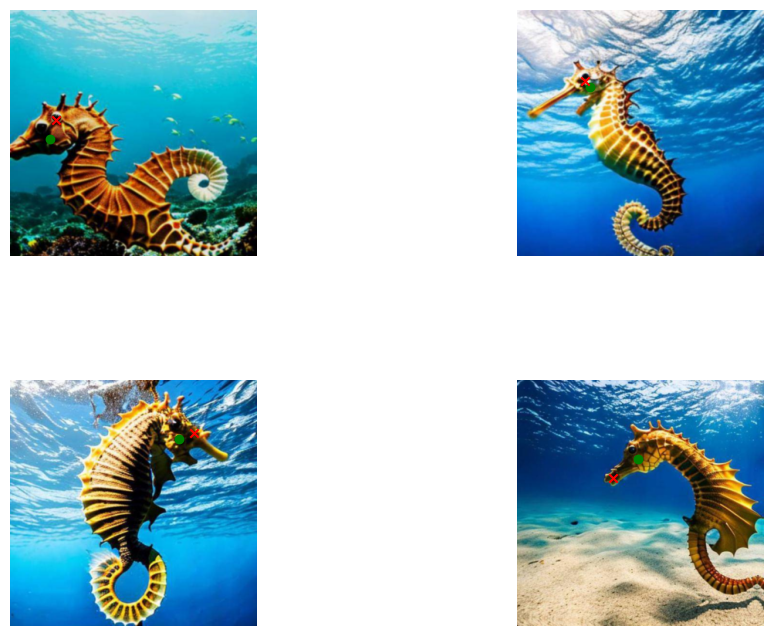

In [ ]:
plot_batch_with_points(images=batch['image'], real_points=batch['center'], predicted_points=centers, rows=2, cols=2)